In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from torch.autograd import Variable

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [2]:
def dataloader_lstm(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
        # print(dataX)
    return np.array(dataX), np.array(dataY)

In [3]:
dataset = []
x = np.linspace(-2 * np.pi, 2 * np.pi, 400)
for i in x:
    data = np.sin(i)
    dataset.append(data)
    
dataset = np.array(dataset)
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [4]:
data_x, data_y = dataloader_lstm(dataset)

data_x = data_x.reshape(-1, 1, 3)
data_y = data_y.reshape(-1, 1, 1)

In [5]:
dataset = TensorDataset(torch.tensor(data_x, dtype=torch.float), torch.tensor(data_y, dtype=torch.float))
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [6]:
class MyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, lstm_layers=2):
        super(MyNet, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, lstm_layers)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x): # x:torch.FloatTensor
        x, _ = self.rnn(x)
        s, b, h = x.shape
        x = x.view(s * b, h)
        x = self.out(x)
        x = x.view(s, b, -1)
        return x

In [7]:
model = MyNet(input_size=3, hidden_size=10)
learning_rate = 0.01

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
epochs = 1000
losses = []
for i in range(epochs):
    for x_batch, y_batch in dataloader:
        y_pred = model.forward(x_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (i + 1) % (epochs / 10) == 0:
        print("epoch: {0} , loss: {1}".format(i + 1, loss.item()))

epoch: 100 , loss: 0.00040883017936721444
epoch: 200 , loss: 8.245466597145423e-05
epoch: 300 , loss: 8.782780241745058e-06
epoch: 400 , loss: 1.1682011972879991e-05
epoch: 500 , loss: 2.452961780363694e-05
epoch: 600 , loss: 2.886939728341531e-05
epoch: 700 , loss: 1.4991893294791225e-05
epoch: 800 , loss: 8.070876356214285e-05
epoch: 900 , loss: 1.851524575613439e-05
epoch: 1000 , loss: 1.872250868473202e-05


In [9]:
def testplot(x, test_x):
    test_x = test_x.reshape(-1, 1, 3)
    test_X = torch.tensor(test_x, dtype=torch.float)
    pred_Y = model.forward(test_X)
    pred_y = pred_Y.view(-1).data.numpy()
    # plt_x = test_x[:, :, 1]
    plt.plot(pred_y, label="Predict")
    # plt.plot(plt_x, np.sin(test_x), label="Ground Truth")
    plt.xlabel("x")
    plt.ylabel("sin(x)")
    plt.legend()
    # plt.savefig(fname="save.png", figsize=[10,10])
    plt.show()

In [10]:
testset = []
x = np.linspace(-4 * np.pi, 4 * np.pi, 1600)
for i in x:
    test_data = np.sin(i)
    testset.append(test_data)
    
testset = np.array(testset)
testset = testset.astype('float32')
max_value = np.max(testset)
min_value = np.min(testset)
scalar = max_value - min_value
testset = list(map(lambda x: x / scalar, testset))

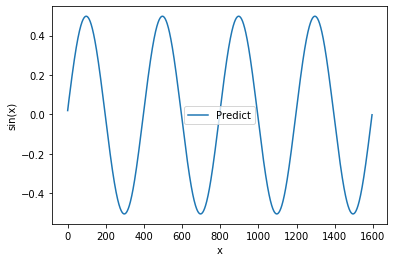

In [11]:
test_x, _ = dataloader_lstm(testset)
testplot(x, test_x)